In [ ]:
import os
import glob
import time
import pickle
import warnings
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns
from numpy import mean, std
import matplotlib.pyplot as plt

from sklearn import preprocessing
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# 1. Data processing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# source: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
transaction_data_urls = [f for f in glob.glob("/content/drive/MyDrive/36106/assignment_3_data/transactions*.csv")]
customer_data_url = '/content/drive/MyDrive/36106/assignment_3_data/customers.csv'

In [ ]:
dfs = []
for url in transaction_data_urls:
    df_temp = pd.read_csv(url, sep='|')
    dfs.append(df_temp)

In [ ]:
trans_df = pd.concat(dfs)
cust_df = pd.read_csv(customer_data_url, sep='|')

In [ ]:
trans_df.sample(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
141472,4642316544137277688,471931004367,602248554e35bd48dcdfa07f232feffb,1669121507,personal_care,70.78,0,Phillips Inc,39.895218,-112.422622
956,4896331812335761701,149852234418,136ed73898fce04b15d0fd219aca5b42,1651042486,misc_net,80.93,0,"Petty, Shaffer and Anderson",39.836923,-90.562500
22667,4056658833987411326,313204503271,052c8b41105d08ac817c2db2fe597e64,1664675266,personal_care,4.03,0,King-Young,45.713176,-122.043455
8243,4885652715598355,288631032701,f1b5d0bcc18fee71e3cc4858ce9e55ec,1671682432,personal_care,3.28,0,"Coleman, Mitchell and Smith",40.476123,-74.390076
26733,6011630702867209,642285306665,cba0ffacc343ed5c3386297775156a9e,1652651334,misc_pos,198.30,0,Smith-Jones,28.644154,-81.552455


In [ ]:
cust_df.sample(5)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
111,268-14-1216,346218159970624,Lawrence,Hamilton,M,53368 Guerrero Hills,Grand Prairie,TX,75052,32.6605,-97.0311,174375,Field seismologist,1982-11-04,51951563323
191,605-53-3909,3582761539669587,Melissa,Thompson,F,971 Nguyen Court,Ada,MI,49301,42.9566,-85.4810,18701,"Producer, television/film/video",1990-08-21,335764110674
852,292-43-6175,4437019453911776664,Gina,Cooper,F,612 Kristen Estate Apt. 578,Boulder,CO,80303,39.9914,-105.2392,120932,Automotive engineer,1938-07-26,727596577485
287,511-38-3310,4303975245086409,Daryl,Quinn,M,38033 Boyd Falls Suite 017,Cheshire,CT,6410,41.5055,-72.9081,29161,Building control surveyor,1927-09-28,214549341145
807,515-75-0442,4379006548708470,Victoria,Carpenter,F,76755 Brittney Club Apt. 737,Amherst,VA,24521,37.6027,-79.0506,10576,"Scientist, audiological",1999-04-03,386831851262


## 1.1. General statistics.

In [ ]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ssn       1000 non-null   object 
 1   cc_num    1000 non-null   int64  
 2   first     1000 non-null   object 
 3   last      1000 non-null   object 
 4   gender    1000 non-null   object 
 5   street    1000 non-null   object 
 6   city      1000 non-null   object 
 7   state     1000 non-null   object 
 8   zip       1000 non-null   int64  
 9   lat       1000 non-null   float64
 10  long      1000 non-null   float64
 11  city_pop  1000 non-null   int64  
 12  job       1000 non-null   object 
 13  dob       1000 non-null   object 
 14  acct_num  1000 non-null   int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 117.3+ KB


In [ ]:
cust_df['cc_num'].nunique()

1000

In [ ]:
cust_df = cust_df.drop_duplicates()

total unique customer ids = 1000, and our customer data has 1000 rows => no duplicate.

In [ ]:
# extract numeric and categorical variables
cust_categorical_features = [col for col in cust_df.columns if (cust_df[col].dtype == 'object')]
cust_numeric_features = [col for col in cust_df.columns if col not in cust_categorical_features]

In [ ]:
for f in cust_categorical_features:
    print(f'Customer data: column {f} unique values: {cust_df[f].str.strip().str.lower().nunique()}')

Customer data: column ssn unique values: 1000
Customer data: column first unique values: 367
Customer data: column last unique values: 487
Customer data: column gender unique values: 2
Customer data: column street unique values: 1000
Customer data: column city unique values: 736
Customer data: column state unique values: 51
Customer data: column job unique values: 507
Customer data: column dob unique values: 978


first, last, street are sensitive data, while city have high cardinality, learning these information might lead to overfitting -> remove them.

In [ ]:
cust_columns_to_drop = ['first', 'last', 'ssn', 'street']
cust_selected_columns = [col for col in cust_df.columns if col not in cust_columns_to_drop]

## 1.2. Join transaction with customer data

In [ ]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4260904 entries, 0 to 25877
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      object 
 1   acct_num    object 
 2   trans_num   object 
 3   unix_time   object 
 4   category    object 
 5   amt         float64
 6   is_fraud    object 
 7   merchant    object 
 8   merch_lat   float64
 9   merch_long  float64
dtypes: float64(3), object(7)
memory usage: 357.6+ MB


In [ ]:
df_merged = trans_df.merge(
    cust_df[cust_selected_columns],
    on=['cc_num', 'acct_num']
)

In [ ]:
df_merged.head(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,gender,city,state,zip,lat,long,city_pop,job,dob
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,Phillips Group,39.491416,-75.588522,M,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
1,4218196001337,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,Tucker Ltd,40.890319,-75.573359,M,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
2,4218196001337,888022315787,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,Dixon PLC,39.244958,-74.475327,M,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
3,4218196001337,888022315787,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,Lambert-Cooper,39.656925,-75.802342,M,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03
4,4218196001337,888022315787,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,Griffith LLC,40.313342,-74.220434,M,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03


In [ ]:
all_columns = list(df_merged.columns)
# extract numeric and categorical variables
categorical_features = [col for col in df_merged.columns if (df_merged[col].dtype == 'object')]
numeric_features = [col for col in all_columns if col not in categorical_features]

In [ ]:
for f in categorical_features:
    print(f'Customer data: column {f} unique values: {df_merged[f].nunique()}')

Customer data: column cc_num unique values: 983
Customer data: column acct_num unique values: 983
Customer data: column trans_num unique values: 4260904
Customer data: column unix_time unique values: 4114752
Customer data: column category unique values: 14
Customer data: column is_fraud unique values: 2
Customer data: column merchant unique values: 21977
Customer data: column gender unique values: 2
Customer data: column city unique values: 726
Customer data: column state unique values: 51
Customer data: column job unique values: 505
Customer data: column dob unique values: 962


## 1.3. Check duplicated data

In [ ]:
sum(df_merged['trans_num'].duplicated())

0

## 1.4. Check missing data

In [ ]:
# count missing values
na_df = pd.DataFrame(df_merged.isnull().sum(), columns=['null_count'])
na_df['null_ratio'] = na_df['null_count']/len(df_merged)
na_df

,null_count,null_ratio
cc_num,0,0.0
acct_num,0,0.0
trans_num,0,0.0
unix_time,0,0.0
category,0,0.0
amt,0,0.0
is_fraud,0,0.0
merchant,0,0.0
merch_lat,0,0.0
merch_long,0,0.0


## 1.5. Standardize categorical values

In [ ]:
categorical_features_to_standardize = [
 'category',
 'merchant',
 'gender',
 'city',
 'state',
 'job'
]
for feature in categorical_features_to_standardize:
    if feature not in ['state', 'gender']:  # do not lower state and gender
        df_merged[feature] = df_merged[feature].str.strip().str.lower()
    else:
        df_merged[feature] = df_merged[feature].str.strip()

In [ ]:
df_merged.head(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,gender,city,state,zip,lat,long,city_pop,job,dob
0,4218196001337,888022315787,91ab12e73ef38206e1121e9648d2408d,1558719550,gas_transport,69.12,0,phillips group,39.491416,-75.588522,M,ambler,PA,19002,40.1809,-75.2156,32412,accounting technician,1959-10-03
1,4218196001337,888022315787,071553d533a6822a4431c354c434ddcb,1569425519,grocery_pos,68.11,0,tucker ltd,40.890319,-75.573359,M,ambler,PA,19002,40.1809,-75.2156,32412,accounting technician,1959-10-03
2,4218196001337,888022315787,0cfad38ef15e4749eff68dc83f62c151,1577205601,misc_net,40.35,0,dixon plc,39.244958,-74.475327,M,ambler,PA,19002,40.1809,-75.2156,32412,accounting technician,1959-10-03
3,4218196001337,888022315787,5782693d7c70f062f258cb30bfa8900f,1571428238,grocery_pos,96.22,0,lambert-cooper,39.656925,-75.802342,M,ambler,PA,19002,40.1809,-75.2156,32412,accounting technician,1959-10-03
4,4218196001337,888022315787,35fd7db657d7e30dd608c37f7798186e,1549840400,gas_transport,71.89,0,griffith llc,40.313342,-74.220434,M,ambler,PA,19002,40.1809,-75.2156,32412,accounting technician,1959-10-03


# 2. Feature engineering

## 2.1. Transaction count in the past intervals: 5 mins, 30 mins, 24 hours.

In [ ]:
# count number of transaction in the past X minutes
df_merged['datetime'] = pd.to_datetime(df_merged['unix_time'], unit='s') # source: https://stackoverflow.com/questions/19231871/convert-unix-time-to-readable-date-in-pandas-dataframe

df_merged_transformed = df_merged.copy()
# df_merged_transformed = df_merged_transformed.set_index('datetime')
# df_merged_transformed = df_merged_transformed.sort_index()
# source: https://www.geeksforgeeks.org/python-pandas-dataframe-rolling/
intervals = ['5min', '30min', '24H']
for interval in intervals:
    df_merged_transformed = df_merged_transformed.set_index('datetime')
    df_merged_transformed = df_merged_transformed.sort_index()
    # group by customer and create a rolling window of the past X minutes
    rolling_window = df_merged_transformed.groupby('cc_num')['trans_num'].rolling(interval)
    # count the number of transactions in each rolling window
    count_transactions = rolling_window.count()
    # reset the index and rename the column
    count_transactions = count_transactions.reset_index()
    count_transactions.rename(columns={'trans_num': f'transactions_past_{interval}'}, inplace=True)
    df_merged_transformed = df_merged_transformed.merge(count_transactions, on=['cc_num', 'datetime'])
    time.sleep(3)

In [ ]:
df_merged_transformed = df_merged_transformed.reset_index()

## 2.2. Calculate age from "dob"

In [ ]:
df_merged_transformed['date_of_birth'] = pd.to_datetime(df_merged_transformed['dob'], format='%Y-%m-%d')
df_merged_transformed['age'] = datetime.today().year - df_merged_transformed['date_of_birth'].dt.year

## 2.3. Calculate the distance between merchant longitude and latitude and customer geo.

In [ ]:
from math import radians, cos, sin, asin, sqrt
# source: https://www.geeksforgeeks.org/program-distance-two-points-earth/
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [ ]:
df_merged_transformed['customer_merchant_distance_km'] = df_merged_transformed.apply(lambda x: 
                                                                                     distance(
                                                                                        lat1=x['merch_lat'],
                                                                                        lat2=x['lat'],
                                                                                        lon1=x['merch_long'],
                                                                                        lon2=x['long']), axis=1)

In [ ]:
df_merged_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4319832 entries, 0 to 4319831
Data columns (total 27 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   index                          int64         
 1   cc_num                         object        
 2   datetime                       datetime64[ns]
 3   acct_num                       object        
 4   trans_num                      object        
 5   unix_time                      object        
 6   category                       object        
 7   amt                            float64       
 8   is_fraud                       object        
 9   merchant                       object        
 10  merch_lat                      float64       
 11  merch_long                     float64       
 12  gender                         object        
 13  city                           object        
 14  state                          object        
 15  zip            

## 2.4. Remove unnecessary features.

In [ ]:
columns_to_remove = ['acct_num', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 
                     'zip', 'lat', 'long', 'dob']
selected_columns = [col for col in df_merged_transformed.columns if col not in columns_to_remove]

In [ ]:
df_transformed = df_merged_transformed[selected_columns].reset_index(drop=True)
df_transformed['is_fraud'] = df_transformed['is_fraud'].astype(int)
transformed_all_columns = list(df_transformed.columns)
# extract numeric and categorical variables
transformed_categorical_features = [col for col in transformed_all_columns if (df_transformed[col].dtype == 'object')]
transformed_numeric_features = [col for col in transformed_all_columns if ((df_transformed[col].dtype == 'int64') | (df_transformed[col].dtype == 'float64'))]

In [ ]:
df_transformed.head(1)

,index,cc_num,datetime,category,amt,is_fraud,merchant,gender,city,state,city_pop,job,transactions_past_5min,transactions_past_30min,transactions_past_24H,date_of_birth,age,customer_merchant_distance_km
0,0,213140433504880,2018-12-31 13:00:19,gas_transport,209.83,0,peterson llc,F,reading,PA,213013,fisheries officer,1.0,1.0,1.0,1989-03-06,34,95.585795


In [ ]:
df_transformed.to_csv('/content/drive/MyDrive/36106/Group_assignment_3-Shared/Dataset/df_transformed.csv', index=False)

To this point, we obtained a unified and clean data that can be used to serve our use cases. 

Some further feature selection and feature engineering steps that serve a specific use case will be conducted in each use case notebook.

In [ ]:
# df_transformed = pd.read_csv('/content/drive/MyDrive/36106/Group_assignment_3-Shared/Dataset/df_transformed.csv')

# 3. EDA.

## 3.1. Plot numeric features distribution.

In [ ]:
transformed_numeric_features.remove('index')
transformed_numeric_features

['amt',
 'is_fraud',
 'city_pop',
 'transactions_past_5min',
 'transactions_past_30min',
 'transactions_past_24H',
 'age',
 'customer_merchant_distance_km']

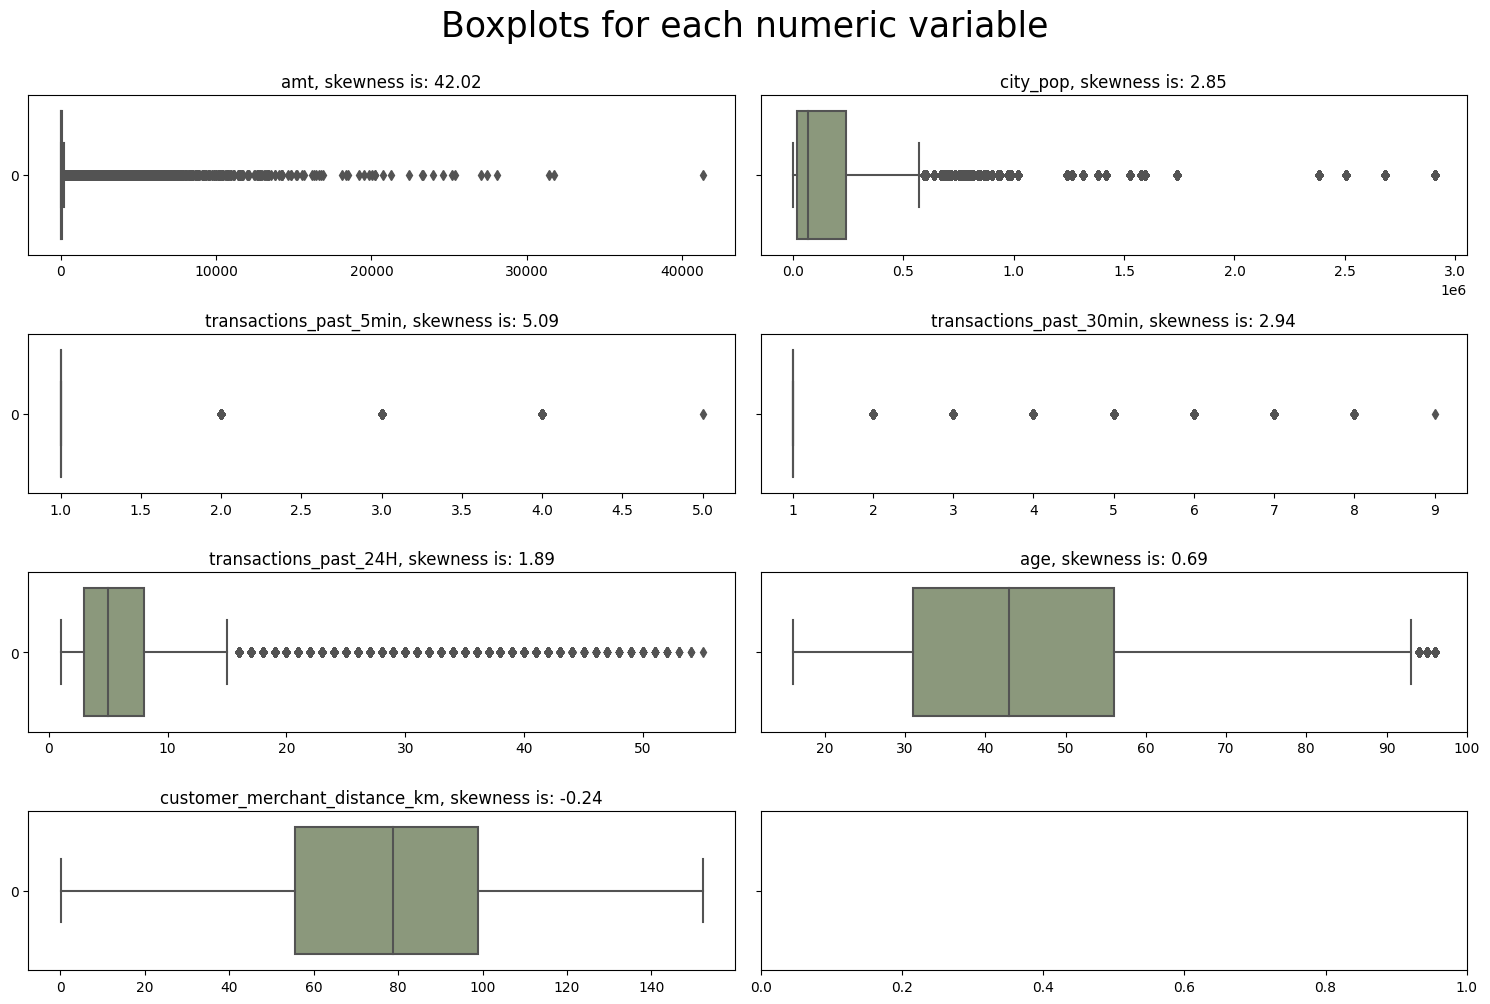

In [ ]:
# source: https://www.kaggle.com/code/marcinrutecki/how-to-create-a-meaningful-eda#3-|-Feature-Distribution
features_to_plot = [
 'amt',
 'city_pop',
 'transactions_past_5min',
 'transactions_past_30min',
 'transactions_past_24H',
 'age',
 'customer_merchant_distance_km']

# checking boxplots
def boxplots_custom(dataset, rows, cols, suptitle, columns_list=None):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(15,10))
    fig.suptitle(suptitle, y=1, size=25)
    axs = axs.flatten()
    if columns_list is None:
        columns_list = list(dataset.columns)
    for i, feature in enumerate(columns_list):
        sns.boxplot(data=dataset[feature], orient='h', ax=axs[i], color="#8B9D77")
        axs[i].set_title(feature + ', skewness is: '+str(round(dataset[feature].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df_transformed, columns_list=features_to_plot, rows=4, cols=2, suptitle='Boxplots for each numeric variable')
plt.tight_layout()

## 3.2. Transform categorical variables.

In [ ]:
transformed_categorical_features

['cc_num', 'category', 'merchant', 'gender', 'city', 'state', 'job']

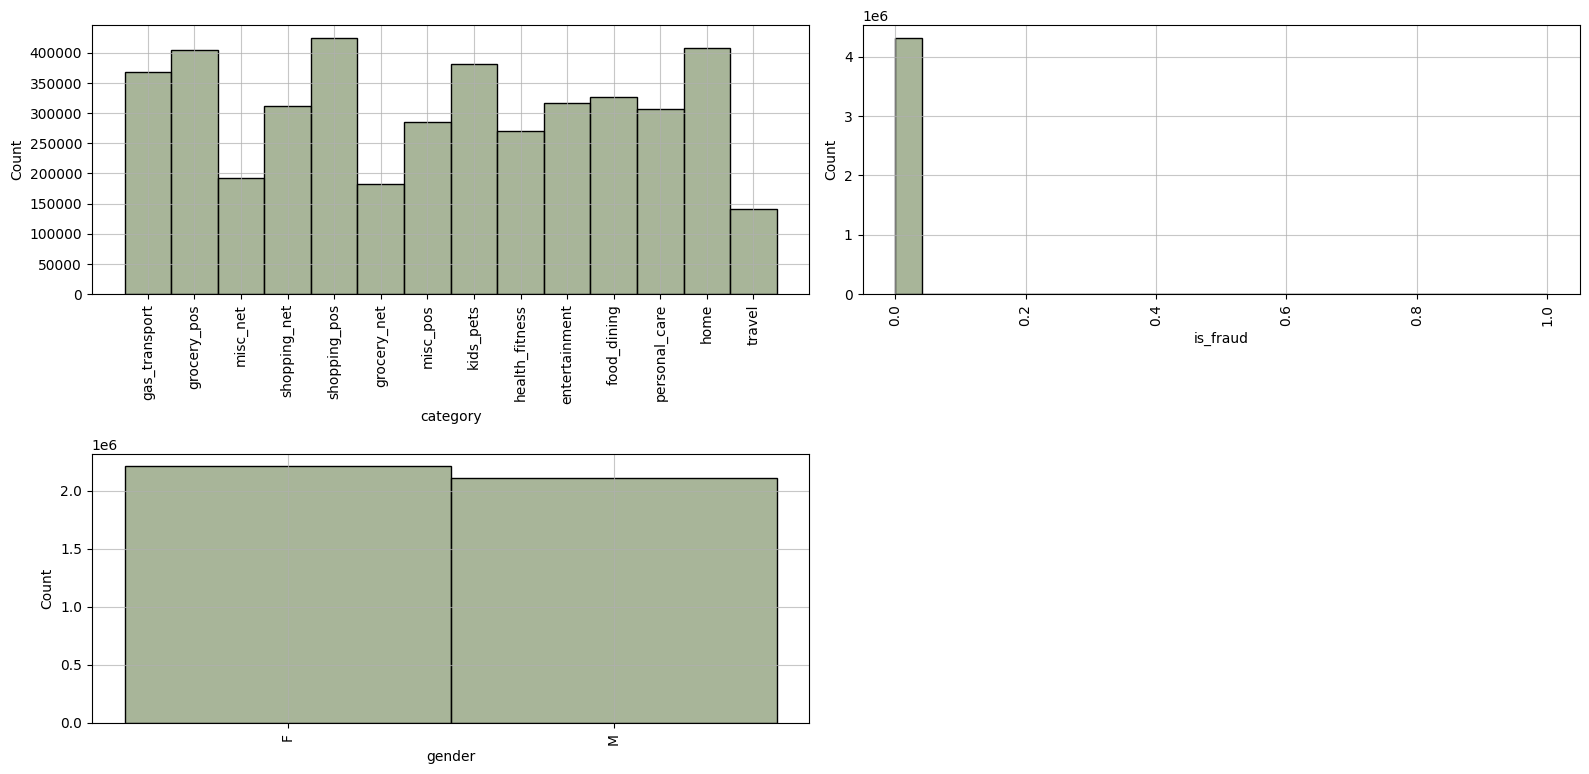

In [ ]:
# source: https://www.kaggle.com/code/marcinrutecki/how-to-create-a-meaningful-eda#3-|-Feature-Distribution

fig = plt.figure(figsize=(16, 16))
rows, cols = 4, 2
for idx, feature in enumerate(['category', 'is_fraud', 'gender']):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.histplot(data = df_transformed, x=feature, multiple='stack', color ="#8B9D77")
    ax.set_xlabel(feature)
    plt.xticks(rotation=90)

fig.tight_layout()
fig.show()

### 3.2.1. "Merchant" column has high cardinality -> remove this feature

In [ ]:
df_transformed.groupby(['merchant'])['amt'].count()

merchant
abbott group                    347
abbott llc                      164
abbott ltd                      148
abbott plc                      141
abbott, bates and meyers         60
                               ... 
zuniga llc                      224
zuniga plc                      157
zuniga, castillo and pacheco    161
zuniga, conley and shepherd     187
zuniga, hernandez and berger    138
Name: amt, Length: 21977, dtype: int64

### 3.2.2. "City" column also has high cardinality -> remove city, use state instead.

In [ ]:
df_transformed.groupby(['city'])['amt'].count()

city
abbottstown       7036
abilene           6172
acton             5096
ada              16294
adairville        3273
                 ...  
york haven        3636
youngtown         1460
yuba city         5454
zapata            3640
zolfo springs      362
Name: amt, Length: 726, dtype: int64

## 3.3. Optional data transformation.
Each use case has different data requirements. Some of the data transformation steps below may not applicable for some use cases.

### 3.3.1. Recategorizing state
Too many states -> only get top popular state, categorize the rest into "other"

In [ ]:
state_count_df = df_transformed.groupby(['state'])['amt'].count().reset_index().sort_values(by='amt', ascending=False)
state_count_df['pct'] = 100*state_count_df['amt']/state_count_df['amt'].sum()

In [ ]:
popular_states = list(state_count_df[state_count_df['pct'] > 4].state.values)
df_transformed.loc[df_transformed['state'].isin(popular_states), 'state_new'] = df_transformed['state']
df_transformed['state_new'].fillna('other', inplace=True)

State values after recategorizing

In [ ]:
df_transformed.groupby('state_new')['amt'].count()

state_new
CA        512538
FL        244110
IL        180760
MI        188530
NY        267667
PA        207872
TX        383130
other    2335225
Name: amt, dtype: int64

### 3.3.2. Recategorize "job". 
There are > 500 different jobs -> choose the top popular jobs, and categorize all other jobs into 'other'

In [ ]:
df_jobs = df_transformed[['amt', 'job']].copy()
job_count_df = df_jobs['job'].str.split(' ').explode().reset_index().groupby('job').agg({'index': 'count'}).sort_values(by='index', ascending=False).reset_index()

In [ ]:
job_count_df.head(15)

,job,index
0,manager,354601
1,officer,328747
2,engineer,244504
3,"engineer,",149447
4,research,131327
5,scientist,127139
6,"designer,",115430
7,"scientist,",106526
8,education,96726
9,health,95984


In [ ]:
# recategorize job
jobs = ['manager', 'officer', 'engineer', 'research',
       'scientist', 'designer', 'scientist', 'education', 'health',
       'teacher', 'chief', 'executive']
for job_short in jobs:
    df_transformed.loc[df_transformed['job'].str.contains(job_short), 'job_short'] = job_short
df_transformed['job_short'].fillna('other', inplace=True)

Values of jobs after recategorizing:

In [ ]:
df_transformed.groupby('job_short')['amt'].count()

job_short
chief          68835
designer      156121
education      81901
engineer      417256
executive      89877
health         95984
manager       352448
officer       232906
other        2330655
research       93066
scientist     233665
teacher       167118
Name: amt, dtype: int64

### 3.3.3. Fraud transactions count by category, job and gender.

- Some categories have large number of fraud transactions -> this feature may be useful in predicting fraud transactions.
- There is not difference in number of fraud transaction by gender.

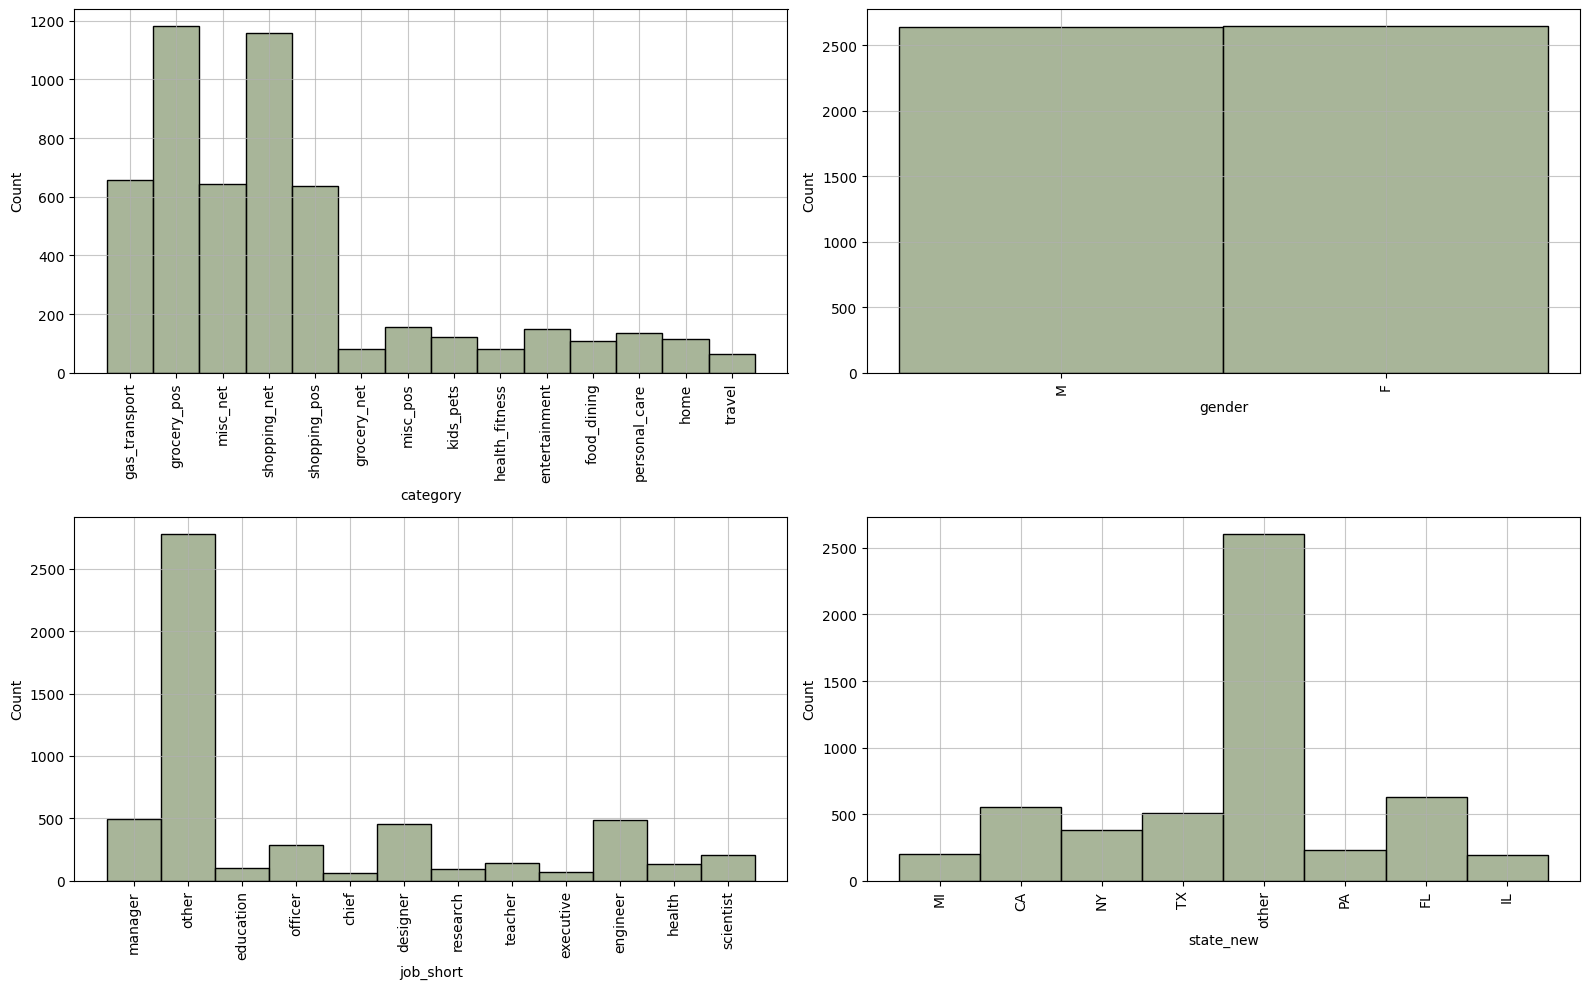

In [ ]:
# source: https://www.kaggle.com/code/marcinrutecki/how-to-create-a-meaningful-eda#3-|-Feature-Distribution

fig = plt.figure(figsize=(16,10))
rows, cols = 2, 2
for idx, feature in enumerate(['category', 'gender', 'job_short', 'state_new']):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.histplot(data = df_transformed[df_transformed['is_fraud']==1], x=feature, multiple='stack', color ="#8B9D77")
    ax.set_xlabel(feature)
    plt.xticks(rotation=90)

fig.tight_layout()
fig.show()

### 3.3.4. One hot encode categorical features

In [ ]:
categorical_features_to_encode = ['state_new', 'job_short', 'category', 'gender']
df_cat_transformed = pd.get_dummies(df_transformed[categorical_features_to_encode])

In [ ]:
df_transformed = pd.concat([df_transformed[transformed_numeric_features], df_cat_transformed], axis=1)
print(df_transformed.info())
df_transformed.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4319832 entries, 0 to 4319831
Data columns (total 44 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   amt                            float64
 1   is_fraud                       int64  
 2   city_pop                       int64  
 3   transactions_past_5min         float64
 4   transactions_past_30min        float64
 5   transactions_past_24H          float64
 6   age                            int64  
 7   customer_merchant_distance_km  float64
 8   state_new_CA                   uint8  
 9   state_new_FL                   uint8  
 10  state_new_IL                   uint8  
 11  state_new_MI                   uint8  
 12  state_new_NY                   uint8  
 13  state_new_PA                   uint8  
 14  state_new_TX                   uint8  
 15  state_new_other                uint8  
 16  job_short_chief                uint8  
 17  job_short_designer             uint8  
 18  jo

,amt,is_fraud,city_pop,transactions_past_5min,transactions_past_30min,transactions_past_24H,age,customer_merchant_distance_km,state_new_CA,state_new_FL,...,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_F,gender_M
0,209.83,0,213013,1.0,1.0,1.0,34,95.585795,0,0,...,0,0,0,0,0,0,0,0,1,0
1,110.47,0,31086,1.0,1.0,1.0,67,62.317054,0,0,...,0,0,0,0,0,0,0,0,1,0
2,9.53,0,1595797,1.0,1.0,1.0,38,2.006383,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
df_transformed.to_csv('/content/drive/MyDrive/36106/Group_assignment_3-Shared/Dataset/at3_ready_for_modeling_data.csv', index=False)